In [2]:
import numpy as np
from random import choice
from sklearn.externals import joblib
import gym
from gym import wrappers
from taxi import TaxiEnv
from tqdm import tqdm_notebook, tnrange, trange

In [3]:
env = TaxiEnv()

In [4]:
n_states = env.observation_space.n
n_actions = env.action_space.n
def get_random_policy():
    """
    Build a numpy array representing agent policy.
    This array must have one element per each of 16 environment states.
    Element must be an integer from 0 to 3, representing action
    to take from that state.
    """
    return np.random.randint(0, n_actions, n_states)


In [5]:
def sample_reward(env, policy, t_max=1000):
    """
    Interact with an environment, return sum of all rewards.
    If game doesn't end on t_max (e.g. agent walks into a wall), 
    force end the game and return whatever reward you got so far.
    Tip: see signature of env.step(...) method above.
    """
    s = env.reset()
    total_reward = 0
    
    for iteration in range(t_max):
        action = policy[s]
        s,r,done,_= env.step(action)
        print(r)
        total_reward+= r
        if (done):
            break
    return total_reward

In [6]:
def evaluate(policy, n_times=100):
    """Run several evaluations and average the score the policy gets."""
    rewards = [sample_reward(env, policy) for _ in range(n_times)]
    return float(np.mean(rewards))
        

In [7]:

n_epochs = 100 #how many cycles to make
pool_size = 100 #how many policies to maintain
n_crossovers = 50 #how many crossovers to make on each step
n_mutations = 50 #how many mutations to make on each tick



In [8]:
def crossover(policy1, policy2, p=0.5):
    """
    for each state, with probability p take action from policy1, else policy2
    """
    crossover_result = np.choose(np.random.choice(np.array([0,1]), 
                                              size=policy1.shape, p=[p, 1-p]), 
                                                  choices=[policy1, policy2])
    
    return crossover_result

In [9]:
np.arange(3)[np.arange(3)<2]

array([0, 1])

In [10]:
def mutation(policy, p=0.1):
    """
    for each state, with probability p replace action with random action
    Tip: mutation can be written as crossover with random policy
    """
    return crossover(get_random_policy(), policy, p)
    

In [11]:
def check_last_n_scores(scores_list, tail_length, min_score):
    return np.all(np.array(scores_list[-tail_length:]) > min_score)

In [12]:
def get_scores(pool):
    return joblib.Parallel(n_jobs=25)(map(joblib.delayed(evaluate), pool))

In [ ]:
#main loop
max_n_epochs = 10
min_score = 0.7
tail_length = 2

best_scores_dict = {}
# for i in trange(10, desc='1st loop'):
#     for j in trange(5, desc='2nd loop', leave=False):
#         for k in trange(100, desc='3nd loop'):
#             sleep(0.01)
for run_idx in tnrange(10, desc='Mutlistart', leave='false'):
    pool = [get_random_policy() for _ in range(pool_size)]
    pool_scores = get_scores(pool)
    epoch_scores = []
    inner_tnrange = tnrange(max_n_epochs, desc=str(run_idx)+' run', leave='true')
    for epoch in inner_tnrange:
        crossovered = [crossover(choice(pool), choice(pool)) for _ in range(n_crossovers)]
        mutated = [mutation(choice(pool)) for _ in range(n_mutations)]

        #add new policies to the pool
        pool = pool + crossovered + mutated
    #     <add up old population with crossovers/mutations>
        pool_scores = get_scores(pool)
    #     <evaluate all policies again>

        #select pool_size best policies
        selected_indices = np.argsort(pool_scores)[-pool_size:]
        pool = [pool[i] for i in selected_indices]
        pool_scores = [pool_scores[i] for i in selected_indices]

        epoch_scores.append(pool_scores[-1])
        inner_tnrange.set_postfix(best_score=pool_scores[-1])
        if np.all(np.array(epoch_scores[-tail_length:]) > min_score):
#             tqmp.write("Stabilized above score {} in {} iterations".format(min_score, epoch))
            break
    if epoch == max_n_epochs:
        tqdm.write('Failed to beat score {} in {} epochs'.format(min_score, max_n_epochs))
    best_scores_dict[epoch] = pool_scores
    
# print best_scores_dict
        #print the best policy so far (last in ascending score order)
#         print("best score:", pool_scores[-1])
    #     print_policy(pool[-1])

In [1]:
print("hello")

hello


It shows, that 45 iterations should be enough to converge to good strategy. So 200 iterations will work out.

In [13]:

pool = [get_random_policy() for _ in range(pool_size)]
pool_scores = get_scores(pool)
n_epochs = 100
inner_tnrange = tnrange(n_epochs, desc=str(run_idx)+' run', leave='true')
epoch_scores = []

for epoch in inner_tnrange:
    crossovered = [crossover(choice(pool), choice(pool)) for _ in range(n_crossovers)]
    mutated = [mutation(choice(pool)) for _ in range(n_mutations)]
    pool = pool + crossovered + mutated
    pool_scores = get_scores(pool)
    selected_indices = np.argsort(pool_scores)[-pool_size:]
    pool = [pool[i] for i in selected_indices]
    pool_scores = [pool_scores[i] for i in selected_indices]
    epoch_scores.append(pool_scores[-1])
    inner_tnrange.set_postfix(best_score=pool_scores[-1])


In [ ]:
print("Converged to strategy with best score {}, average score after {} epochs is {}".format(pool_scores[-1], 
      n_epochs, np.mean(pool_scores)))

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

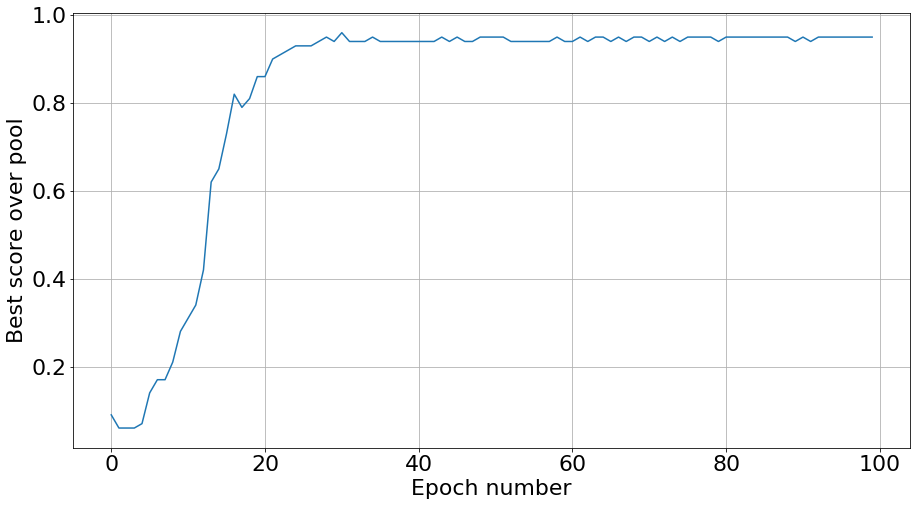

In [19]:
plt.figure(figsize=(15,8))

plt.plot(np.arange(100), epoch_scores)
plt.xlabel('Epoch number')
plt.ylabel('Best score over pool')
plt.grid()

As we can see from the plot, 40 epochs are enough.